Chest X-Ray (Pneumonia): Analyzing the Dataset

# <a id="1">Dataset Information</a> 

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

2021-11-17 08:33:58.178785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 08:33:58.178807: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [31]:
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------train
#                  !-------------test
#                  !-------------val
#
main_path = "./chest_xray_data/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [34]:
# creation of 3 datasets train, test, val

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                        columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), 
                       columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val= pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), 
                     columns = ['class'])
df_val['image'] = [x for x in val_list]

In [35]:
df_train

,class,image
0,Normal,./chest_xray_data/train/NORMAL/IM-0713-0001.jpeg
1,Normal,./chest_xray_data/train/NORMAL/NORMAL2-IM-0636-0001.jpeg
2,Normal,./chest_xray_data/train/NORMAL/IM-0365-0001.jpeg
3,Normal,./chest_xray_data/train/NORMAL/NORMAL2-IM-1285-0001.jpeg
4,Normal,./chest_xray_data/train/NORMAL/IM-0703-0001.jpeg
...,...,...
5211,Pneumonia,./chest_xray_data/train/PNEUMONIA/person1430_virus_2444.jpeg
5212,Pneumonia,./chest_xray_data/train/PNEUMONIA/person1451_virus_2479.jpeg
5213,Pneumonia,./chest_xray_data/train/PNEUMONIA/person316_virus_641.jpeg
5214,Pneumonia,./chest_xray_data/train/PNEUMONIA/person281_bacteria_1327.jpeg


In [36]:
df_test

,class,image
0,Normal,./chest_xray_data/test/NORMAL/NORMAL2-IM-0366-0001.jpeg
1,Normal,./chest_xray_data/test/NORMAL/IM-0039-0001.jpeg
2,Normal,./chest_xray_data/test/NORMAL/IM-0035-0001.jpeg
3,Normal,./chest_xray_data/test/NORMAL/IM-0105-0001.jpeg
4,Normal,./chest_xray_data/test/NORMAL/IM-0063-0001.jpeg
...,...,...
619,Pneumonia,./chest_xray_data/test/PNEUMONIA/person155_bacteria_730.jpeg
620,Pneumonia,./chest_xray_data/test/PNEUMONIA/person81_bacteria_396.jpeg
621,Pneumonia,./chest_xray_data/test/PNEUMONIA/person78_virus_140.jpeg
622,Pneumonia,./chest_xray_data/test/PNEUMONIA/person1635_virus_2831.jpeg


# <a id="3">Exploring the Data</a> 

Let's check the target distribution on each set

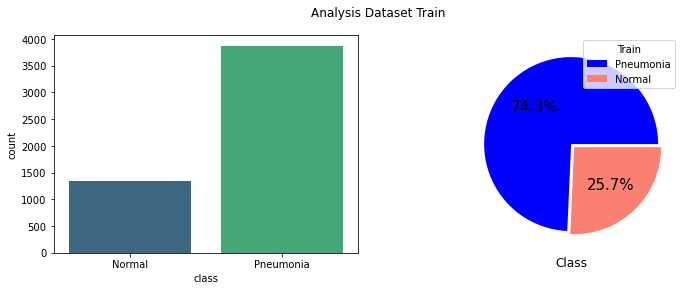

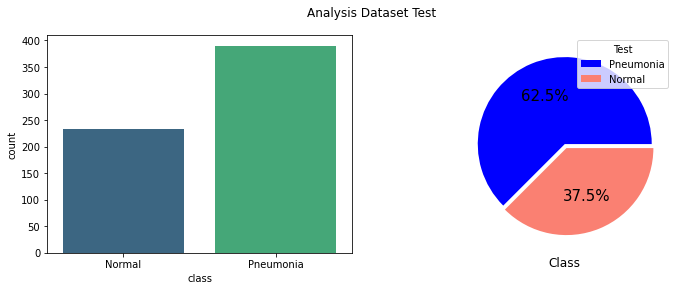

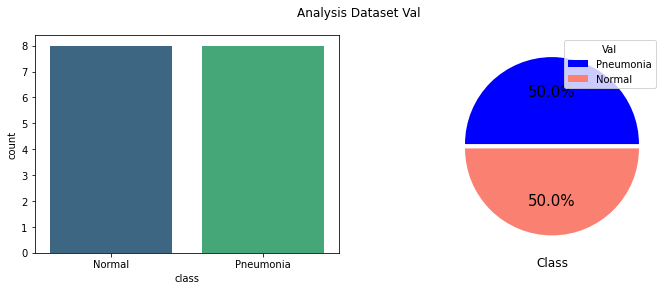

In [38]:
def visualizing_data(df, Name_title):

#   plt.figure(figsize=(6,4))

   fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    
   fig.suptitle('Analysis Dataset '+ Name_title)
   sns.countplot(x='class', data=df, palette="viridis", ax = axes[0])
   axes[0] = plt.xlabel("Class", fontsize= 12)


   axes[1] = plt.pie(df['class'].value_counts(), labels = ['',''],colors = ['blue','salmon'], 
                      explode = [0,0.05], textprops = {"fontsize":15},autopct='%1.1f%%')
#   axes[0].set_suptitle('pollo')
   axes[1]= plt.legend(labels=['Pneumonia', 'Normal'])
   axes[1].set_title(Name_title)
   plt.show()
   return
#plt.legend(labels=['Pneumonia', 'Normal'])

visualizing_data(df_train,'Train') 
visualizing_data(df_test,'Test') 
visualizing_data(df_val,'Val')    

The distributions from these datasets are a little different from each other. Both are slightly imbalanced, having more samples from the positive class (Pneumonia), with the training set being a little more imbalanced.

Before we move on to the next section, we will take a look at a few examples from each dataset.

Train Set - Normal


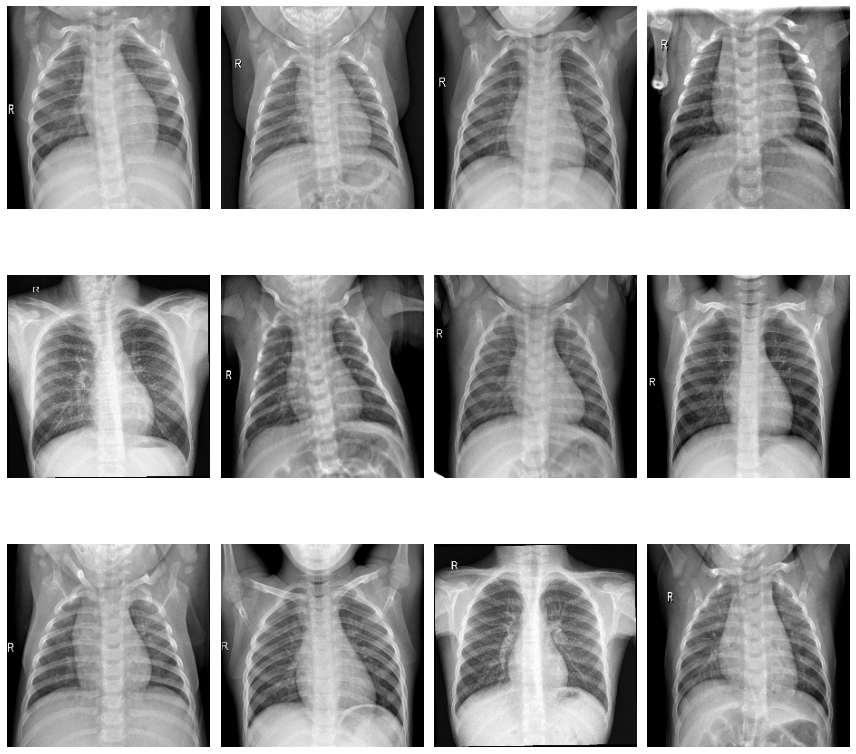

In [33]:
#Train Set - Normal

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Train Set - Normal')

plt.show()

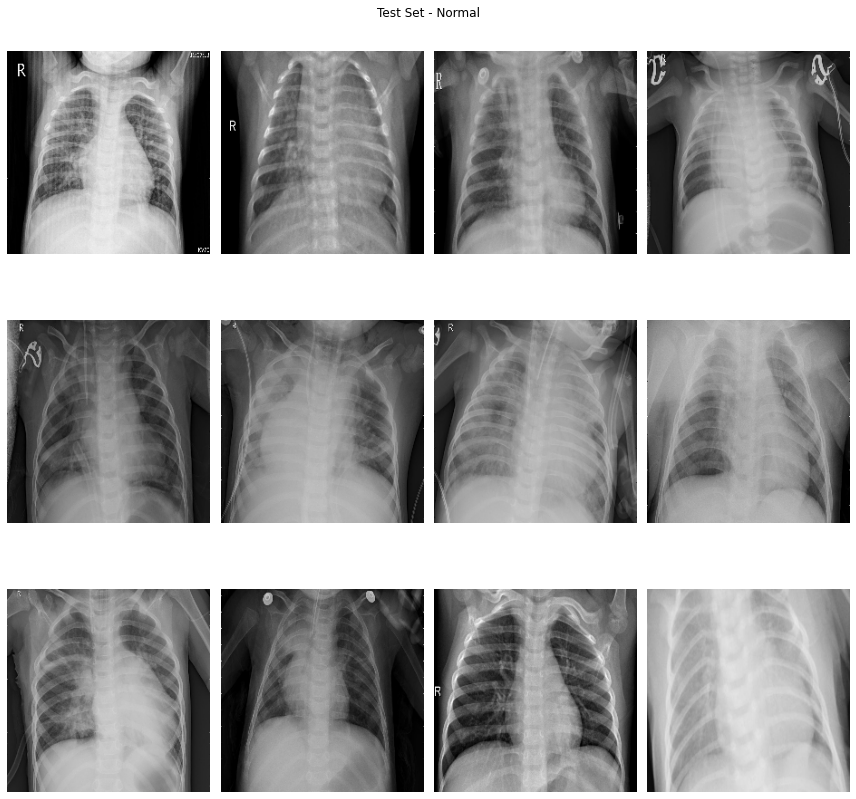

In [41]:
# Train Set - Pneumonia

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Test Set - Pneumonia')

plt.show()

Test Set - Normal


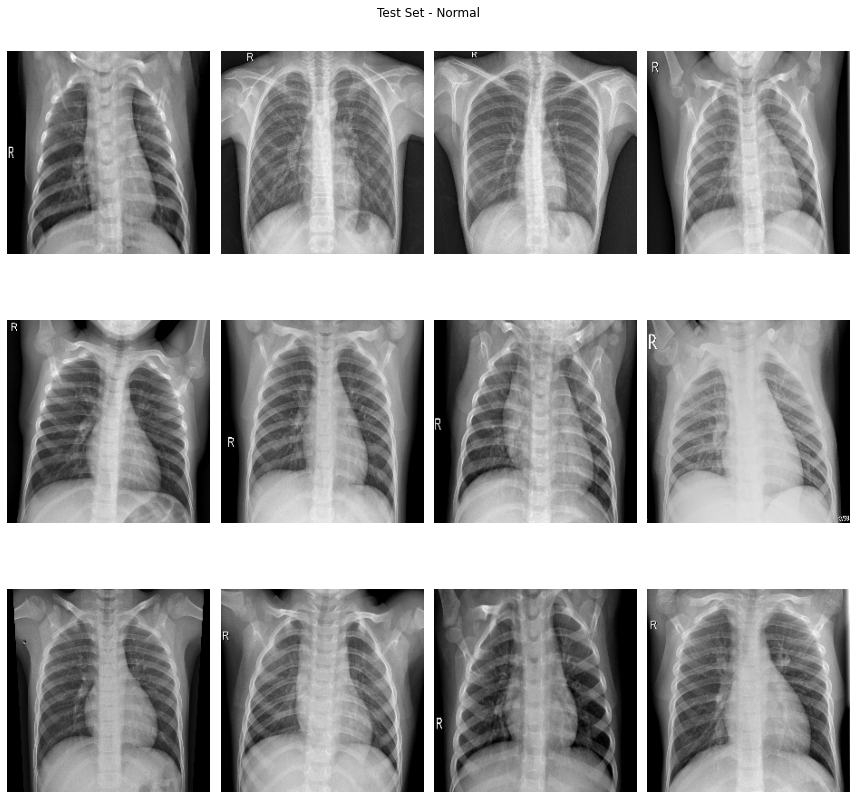

In [39]:
# test set normal
plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Test Set - Normal')

plt.show()

Test Set - Pneumonia


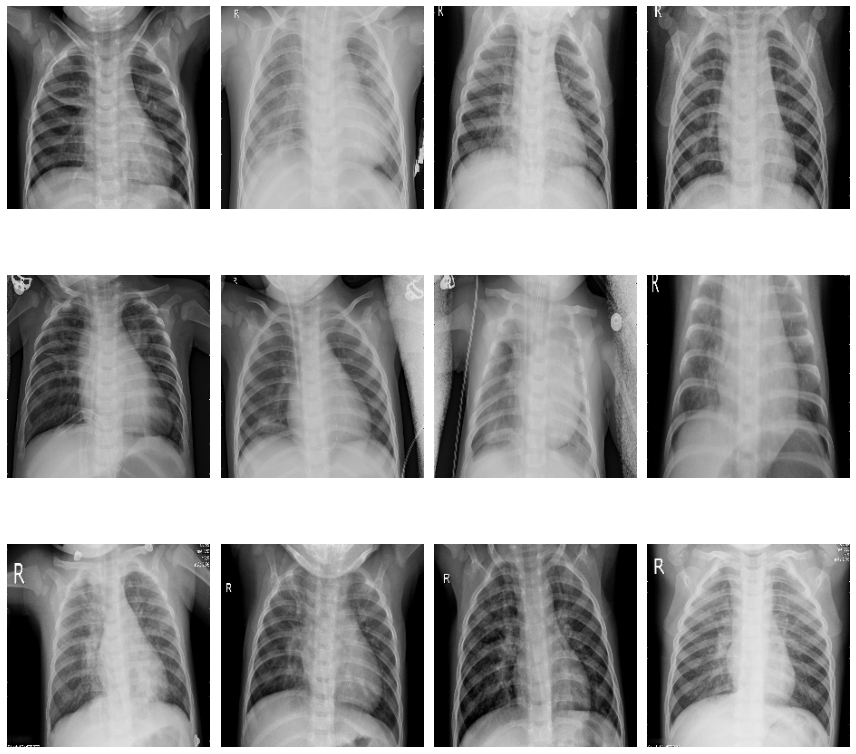

In [36]:
# Test Set - Pneumonia

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Test Set - Normal')

plt.show()

# <a id="4">Preparing the Data</a> 

First, we need to create a validation set. To do that, we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [37]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [38]:
train_df

,class,image
3566,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/VIRUS-6559742-0002.jpeg
2866,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-4609274-0001.jpeg
2681,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/VIRUS-1149864-0002.jpeg
1199,Normal,../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-6315622-0002.jpeg
4619,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-1753514-0002.jpeg
...,...,...
3476,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/VIRUS-3408906-0008.jpeg
678,Normal,../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-4688588-0001.jpeg
1560,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-8467199-0001.jpeg
2769,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-6909155-0001.jpeg


In [39]:
val_df

,class,image
2945,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-2474652-0008.jpeg
4878,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-2739133-0001.jpeg
3177,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-4133607-0005.jpeg
972,Normal,../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-3476904-0001.jpeg
3059,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/VIRUS-8446214-0003.jpeg
...,...,...
253,Normal,../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-9862823-0002.jpeg
4315,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-1083680-0014.jpeg
687,Normal,../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-8991560-0001.jpeg
3417,Pneumonia,../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-7942103-0006.jpeg


Now, we’re going to load the images from the folders and prepare them to feed our models. 

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [40]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Now, we are ready for the next stage: creating and training the image classification models.

# <a id="5">Custom CNN</a>

In [41]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

Let’s define our first model ‘from scratch’ and see how it performs.

In [42]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [43]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00003), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640  

In [44]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 128s 973ms/step - loss: 0.6391 - binary_accuracy: 0.7145 - val_loss: 0.7722 - val_binary_accuracy: 0.7421
Epoch 2/50
130/130 [==============================] - 101s 773ms/step - loss: 0.3928 - binary_accuracy: 0.8159 - val_loss: 1.2521 - val_binary_accuracy: 0.7421
Epoch 3/50
130/130 [==============================] - 101s 772ms/step - loss: 0.3035 - binary_accuracy: 0.8698 - val_loss: 1.4061 - val_binary_accuracy: 0.7421

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
Epoch 4/50
130/130 [==============================] - 101s 771ms/step - loss: 0.2445 - binary_accuracy: 0.8957 - val_loss: 1.1610 - val_binary_accuracy: 0.7421
Epoch 5/50
130/130 [==============================] - 106s 808ms/step - loss: 0.2176 - binary_accuracy: 0.9116 - val_loss: 0.5502 - val_binary_accuracy: 0.7784
Epoch 6/50
130/130 [==============================] - 101s 771ms/step - loss: 0.2325 - binary_accuracy: 0.9110 - val_l

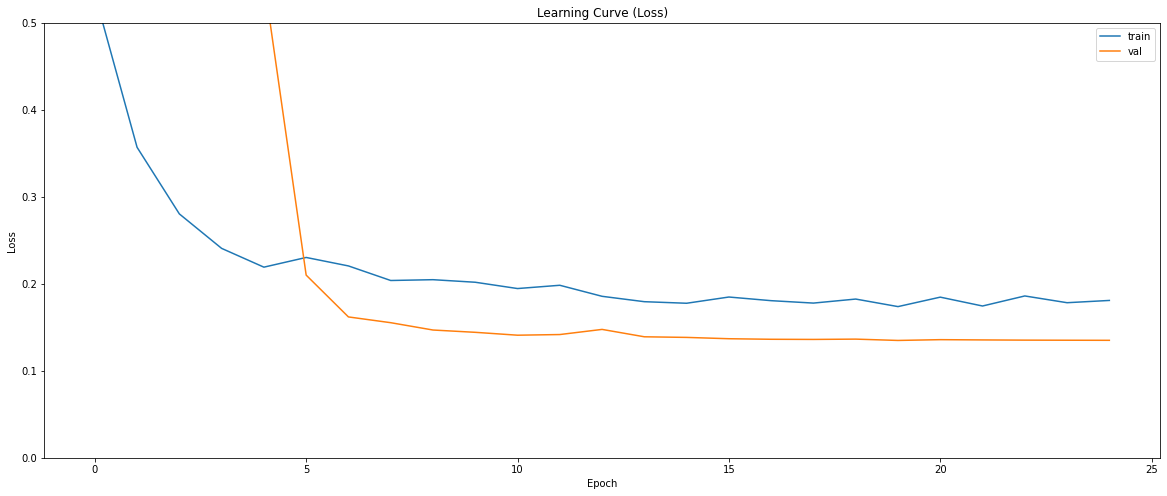

In [45]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

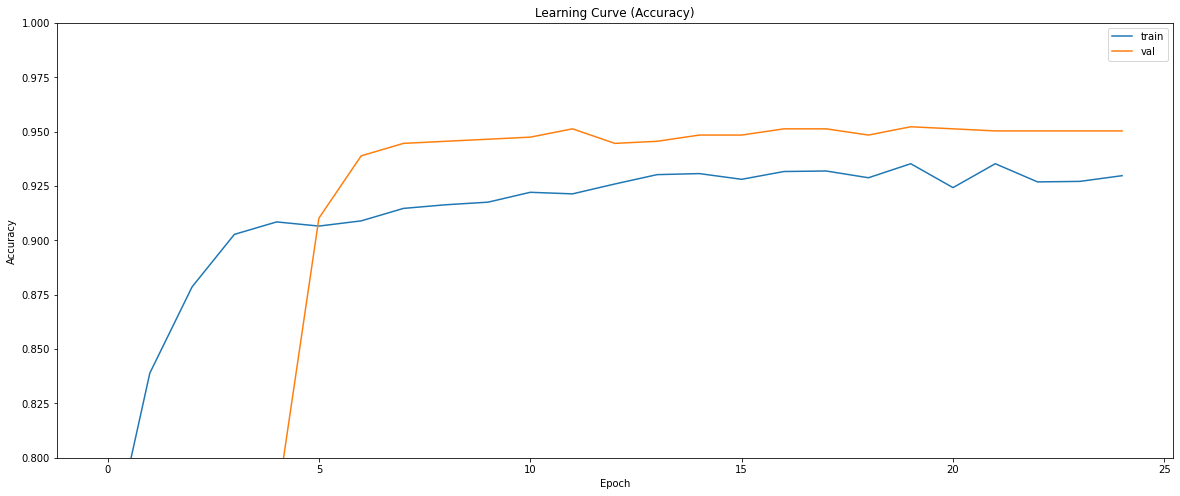

In [46]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [47]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1349286437034607
Val accuracy: 0.9522445201873779


In [48]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4296790361404419
Test accuracy: 0.8493589758872986


# <a id="6">Transfer Learning</a> 

The second approach, called transfer learning, consists of using a pretrained model as a feature extractor. In this notebook, the selected model was the ResNet152V2 available on the Keras Package [(link)](https://keras.io/api/applications/resnet/#resnet152v2-function). 

This model was already trained in another dataset (ImageNet). What we do here is to set include_top to false, removing the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers. Then, we include our last few layers, including the one responsible for generating the output.



In [49]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

234553344/234545216 [==============================] - 1s 0us/step


In [50]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [51]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 115s 817ms/step - loss: 0.6397 - binary_accuracy: 0.6697 - val_loss: 0.2379 - val_binary_accuracy: 0.9179
Epoch 2/50
130/130 [==============================] - 104s 791ms/step - loss: 0.2347 - binary_accuracy: 0.9156 - val_loss: 0.1784 - val_binary_accuracy: 0.9379
Epoch 3/50
130/130 [==============================] - 103s 789ms/step - loss: 0.1833 - binary_accuracy: 0.9363 - val_loss: 0.1586 - val_binary_accuracy: 0.9475
Epoch 4/50
130/130 [==============================] - 104s 795ms/step - loss: 0.1761 - binary_accuracy: 0.9292 - val_loss: 0.1418 - val_binary_accuracy: 0.9522
Epoch 5/50
130/130 [==============================] - 103s 788ms/step - loss: 0.1471 - binary_accuracy: 0.9466 - val_loss: 0.1347 - val_binary_accuracy: 0.9561
Epoch 6/50
130/130 [==============================] - 104s 792ms/step - loss: 0.1403 - binary_accuracy: 0.9473 - val_loss: 0.1278 - val_binary_accuracy: 0.9561
Epoch 7/50
130/130 [====================

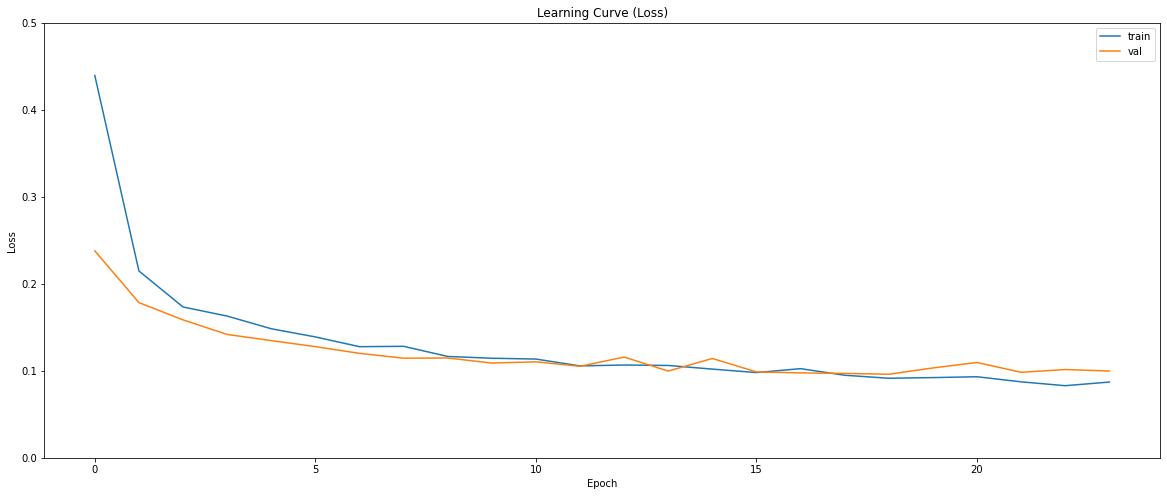

In [52]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

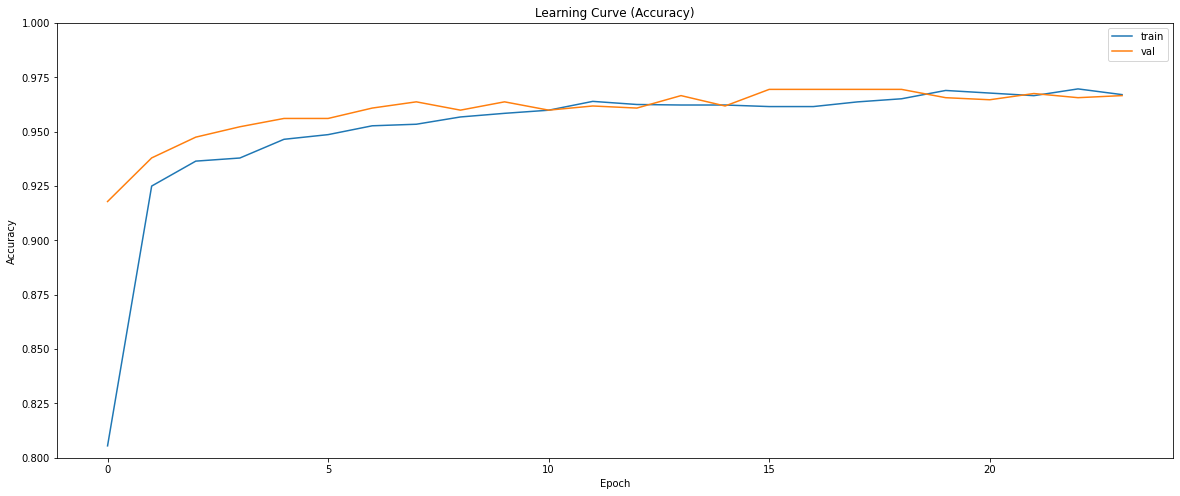

In [53]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [54]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.09604005515575409
Val accuracy: 0.9694364666938782


In [55]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.28737810254096985
Test accuracy: 0.8814102411270142


# <a id="7">Fine Tuning</a> 

Our last approach is called Fine Tuning. In the last section, all the layers from the pretrained model were ‘frozen’, preserving the weights calculated during its training on the ImageNet dataset. Now, we are going to unfreeze a few of its last layers and continue the training, tuning the weights from these layers according to our dataset.

In [56]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [57]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [58]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.000002), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 4,731,137
Non-trainable params: 53,862,912
_________________________________________

In [59]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 113s 802ms/step - loss: 0.1846 - binary_accuracy: 0.9259 - val_loss: 0.1790 - val_binary_accuracy: 0.9446
Epoch 2/50
130/130 [==============================] - 105s 805ms/step - loss: 0.1608 - binary_accuracy: 0.9419 - val_loss: 0.1463 - val_binary_accuracy: 0.9570
Epoch 3/50
130/130 [==============================] - 107s 818ms/step - loss: 0.1316 - binary_accuracy: 0.9564 - val_loss: 0.1318 - val_binary_accuracy: 0.9608
Epoch 4/50
130/130 [==============================] - 103s 790ms/step - loss: 0.1370 - binary_accuracy: 0.9554 - val_loss: 0.1272 - val_binary_accuracy: 0.9608
Epoch 5/50
130/130 [==============================] - 104s 793ms/step - loss: 0.1315 - binary_accuracy: 0.9561 - val_loss: 0.1232 - val_binary_accuracy: 0.9628
Epoch 6/50
130/130 [==============================] - 104s 792ms/step - loss: 0.1176 - binary_accuracy: 0.9576 - val_loss: 0.1206 - val_binary_accuracy: 0.9618
Epoch 7/50
130/130 [====================

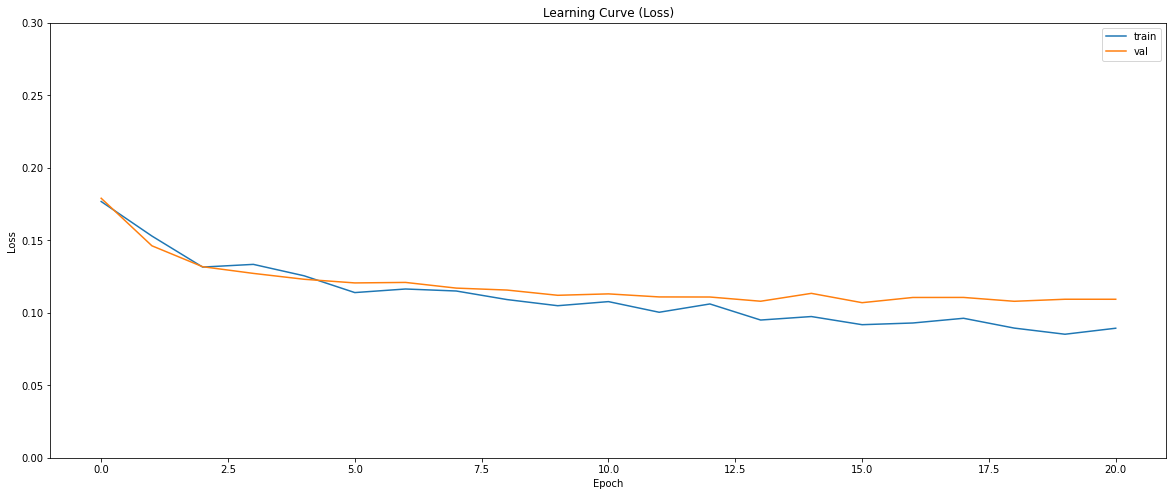

In [70]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

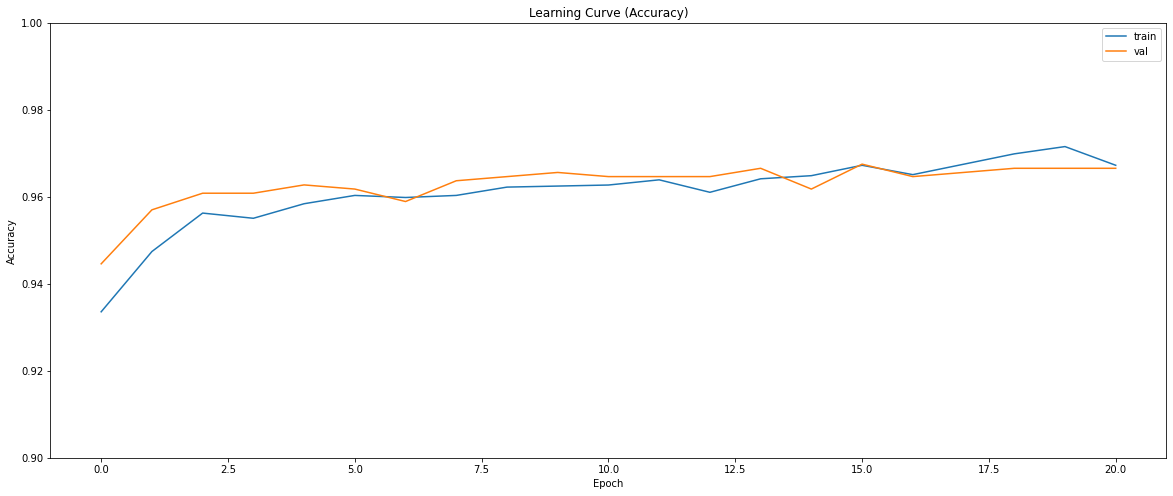

In [71]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [62]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.10701081901788712
Val accuracy: 0.9675262570381165


In [63]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21019524335861206
Test accuracy: 0.9198718070983887


As expected, the fine-tuning approach has reached the best score. We end this notebook by showing a few performance metrics.

# <a id="8">Performance Metrics</a> 

In [64]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [65]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [66]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9198717948717948


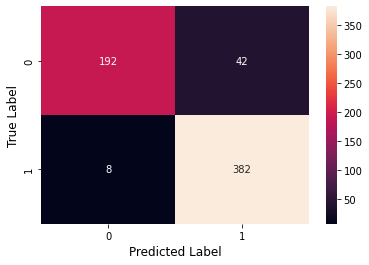

In [67]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [68]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       234
           1       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



ROC_AUC:  0.9779092702169625


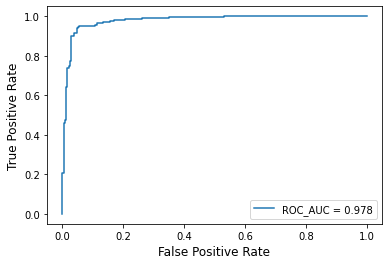

In [69]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

The recall was close to 100%. Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.

# <a id="9">References</a> 

- https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
- https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb
- https://www.tensorflow.org/guide/keras/transfer_learning
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://keras.io/api/applications/
- https://keras.io/api/applications/resnet/#resnet152v2-function

## <center> If you find this notebook useful, support with an upvote! <center>